In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image


In [2]:
SEED = 123

# HEIGHT, WIDTH = 248, 496
# HEIGHT, WIDTH = 256, 256
HEIGHT, WIDTH = 224, 224


---

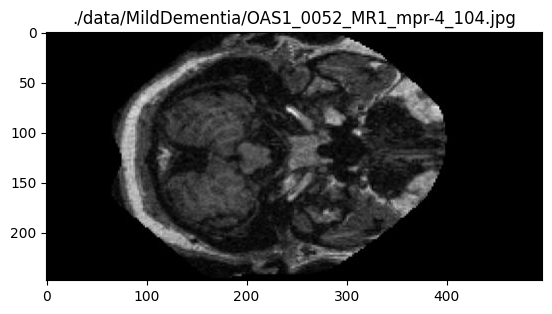

MildDementia
total 5002
ndim {3}
width {496}
height {248}
max 255



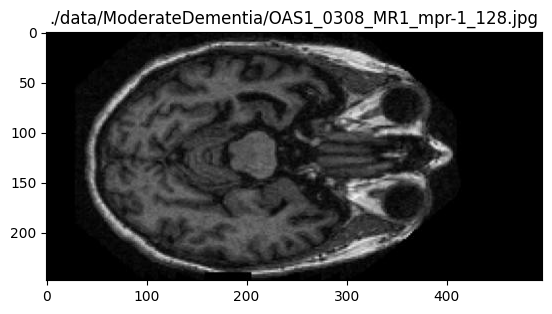

ModerateDementia
total 488
ndim {3}
width {496}
height {248}
max 255



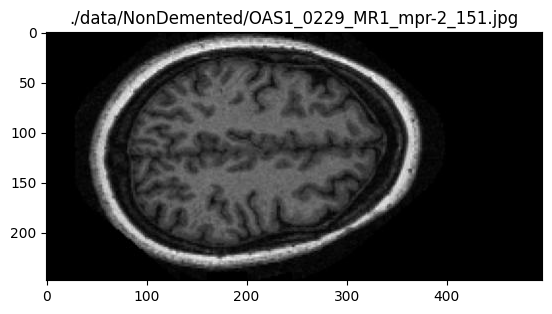

NonDemented
total 67222
ndim {3}
width {496}
height {248}
max 255



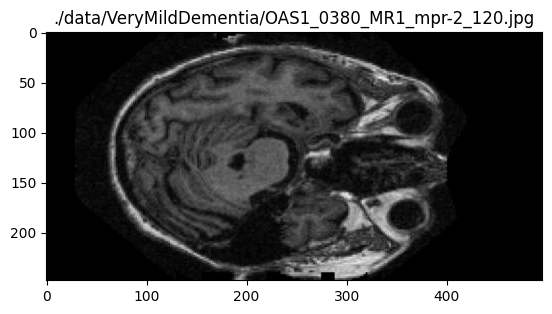

VeryMildDementia
total 13725
ndim {3}
width {496}
height {248}
max 255



In [3]:
data_dir = './data'
classes = ['MildDementia', 'ModerateDementia', 'NonDemented', 'VeryMildDementia']
img_paths, img_labs = [], []
lab_counts = {}

for cls in classes:
    dim, width, height, pix = [], [], [], []

    cls_path = os.path.join(data_dir, cls)
    for file_path in os.listdir(cls_path):
        if not file_path.endswith('.jpg'):
            continue
        file_path = os.path.join(cls_path, file_path)
        img_paths.append(file_path)
        img_labs.append(cls)
        
        with Image.open(file_path) as infile:
            img = np.asarray(infile)
        dim.append(img.ndim)
        width.append(img.shape[1])
        height.append(img.shape[0])
        pix.append(img.max())

    plt.figure()
    plt.imshow(img)
    plt.title(file_path)
    plt.show()

    lab_counts[cls] = len(dim)
    print(cls)
    print('total', len(dim))
    print('ndim', set(dim))
    print('width', set(width))
    print('height', set(height))
    print('max', max(pix))
    print()
    
del img, dim, width, height, pix

In [4]:
# Sample a subset of the data becuase I'm not made of money (or time)
df = pd.DataFrame({'filename': img_paths, 'class': img_labs})
# df = pd.concat([
#     df[df['class']=='ModerateDementia'],
#     df[df['class']=='MildDementia'].sample(n=500, replace=False, random_state=SEED),
#     df[df['class']=='VeryMildDementia'].sample(n=500, replace=False, random_state=SEED),
#     df[df['class']=='NonDemented'].sample(n=500, replace=False, random_state=SEED),
# ]).sample(frac=1., replace=False, random_state=SEED)
df = pd.concat([
    df[df['class']=='ModerateDementia'],
    df[df['class']=='MildDementia'],
    df[df['class']=='VeryMildDementia'],
    df[df['class']=='NonDemented'].sample(n=25000, replace=False, random_state=SEED),
]).sample(frac=1., replace=False, random_state=SEED)

In [5]:
df['class'].value_counts()[classes]

class
MildDementia         5002
ModerateDementia      488
NonDemented         25000
VeryMildDementia    13725
Name: count, dtype: int64

In [6]:
df_train, df_test = train_test_split(
    df, test_size=10000, shuffle=True, random_state=SEED, stratify=df['class']
)

In [7]:
df_train, df_val = train_test_split(
    df_train, test_size=10000, shuffle=True, random_state=SEED, stratify=df_train['class']
)

In [8]:
print('train', len(df_train))
print('val', len(df_val))
print('test', len(df_test))

train 24215
val 10000
test 10000


In [9]:
df_train['weight'] = compute_sample_weight('balanced', y=df_train['class'])
df_val['weight'] = compute_sample_weight('balanced', y=df_val['class'])
# lab_counts_train = df_train['class'].value_counts()
# weights = np.array([lab_counts_train[c] for c in classes])
# weights = weights.sum() / (weights.size * weights)
# weights

In [10]:
init_kwargs = dict(
    data_format='channels_last',
    validation_split=0.,
    rescale=1/255,
    fill_mode='constant',
    cval=0.,
)
flow_kwargs = dict(
    target_size=(HEIGHT, WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=SEED,
)

train_datagen = ImageDataGenerator(
    rotation_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.,
    zoom_range=0.01,
    channel_shift_range=0.,
    horizontal_flip=False,
    vertical_flip=False,
    **init_kwargs
).flow_from_dataframe(df_train, weight_col='weight', **flow_kwargs)

val_datagen = ImageDataGenerator(
    **init_kwargs
).flow_from_dataframe(df_val, weight_col='weight', **flow_kwargs)

test_datagen = ImageDataGenerator(
    **init_kwargs
).flow_from_dataframe(df_test, **flow_kwargs)

Found 24215 validated image filenames belonging to 4 classes.
Found 10000 validated image filenames belonging to 4 classes.
Found 10000 validated image filenames belonging to 4 classes.


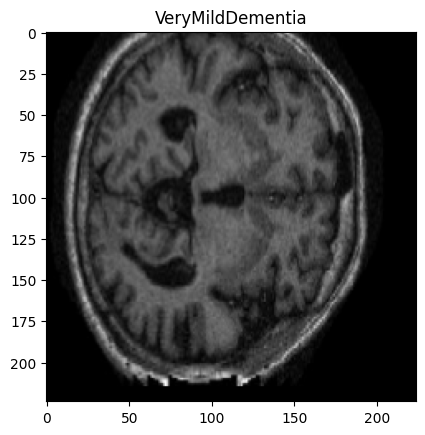

In [11]:
img, lab, wgt = next(iter(train_datagen))
plt.figure()
plt.imshow(img[0,:,:,:])
plt.title(classes[lab[0].argmax()])
plt.show()
del img, lab, wgt

---

In [12]:
# alzheimers_detection_model_6

x_in = layers.Input(shape=(HEIGHT, WIDTH, 3))

x = layers.Conv2D(16, (3, 3))(x_in)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(32, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(32, (3, 3))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(64, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, (3, 3))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.Conv2D(128, (2, 2))(x)
x = layers.Activation('leaky_relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='leaky_relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(classes), activation='softmax')(x)

model = Model(x_in, x)

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.F1Score(average='macro', name='f1'),
]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=25, restore_best_weights=True)
history = model.fit(
    train_datagen,
    epochs=100,
    validation_data=val_datagen,
    # class_weight=dict(enumerate(weights)),
    callbacks=[early_stopping],
    verbose=1,
)

/Users/williamarliss/PyEnvs/stat6202/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 718s 946ms/step - accuracy: 0.3484 - f1: 0.2624 - loss: 1.9370 - val_accuracy: 0.5659 - val_f1: 0.1977 - val_loss: 1.3721
Epoch 2/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 748s 987ms/step - accuracy: 0.4673 - f1: 0.3569 - loss: 1.1507 - val_accuracy: 0.5879 - val_f1: 0.3570 - val_loss: 0.9892
Epoch 3/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 704s 929ms/step - accuracy: 0.4824 - f1: 0.3698 - loss: 1.1076 - val_accuracy: 0.6663 - val_f1: 0.5343 - val_loss: 1.1337
Epoch 4/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 734s 969ms/step - accuracy: 0.5736 - f1: 0.4478 - loss: 0.8747 - val_accuracy: 0.6622 - val_f1: 0.5205 - val_loss: 0.8928
Epoch 5/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 738s 974ms/step - accuracy: 0.5592 - f1: 0.4372 - loss: 0.9614 - val_accuracy: 0.6150 - val_f1: 0.4825 - val_loss: 0.6922
Epoch 6/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 694s 916ms/step - accuracy: 0.6058 - f1: 0.4894 - loss: 0.8064 - val_accuracy: 0.7149 - val_f1: 0.6024 - val_loss: 0.5535
Epoch 7/100
757/757 ━━

757/757 ━━━━━━━━━━━━━━━━━━━━ 700s 925ms/step - accuracy: 0.7118 - f1: 0.6034 - loss: 0.7335 - val_accuracy: 0.8231 - val_f1: 0.7262 - val_loss: 0.3314
Epoch 43/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 692s 914ms/step - accuracy: 0.7788 - f1: 0.6960 - loss: 0.4598 - val_accuracy: 0.8891 - val_f1: 0.9007 - val_loss: 0.2340
Epoch 44/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 675s 890ms/step - accuracy: 0.8018 - f1: 0.7411 - loss: 0.3981 - val_accuracy: 0.8432 - val_f1: 0.8138 - val_loss: 0.3087
Epoch 45/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 682s 901ms/step - accuracy: 0.8095 - f1: 0.7840 - loss: 0.3334 - val_accuracy: 0.8858 - val_f1: 0.9074 - val_loss: 0.2259
Epoch 46/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 654s 864ms/step - accuracy: 0.7591 - f1: 0.6792 - loss: 0.6052 - val_accuracy: 0.8232 - val_f1: 0.7833 - val_loss: 0.3253
Epoch 47/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 681s 899ms/step - accuracy: 0.7745 - f1: 0.6967 - loss: 0.4680 - val_accuracy: 0.8341 - val_f1: 0.7708 - val_loss: 0.2915
Epoch 48/100
757/757 ━━━━━━━━

757/757 ━━━━━━━━━━━━━━━━━━━━ 648s 855ms/step - accuracy: 0.7063 - f1: 0.5940 - loss: 1.1227 - val_accuracy: 0.8388 - val_f1: 0.8507 - val_loss: 0.3178
Epoch 84/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 634s 836ms/step - accuracy: 0.8029 - f1: 0.7447 - loss: 0.4055 - val_accuracy: 0.5325 - val_f1: 0.4324 - val_loss: 1.4521
Epoch 85/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 631s 833ms/step - accuracy: 0.7788 - f1: 0.7347 - loss: 0.4257 - val_accuracy: 0.8968 - val_f1: 0.9166 - val_loss: 0.2219
Epoch 86/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 649s 856ms/step - accuracy: 0.8285 - f1: 0.8196 - loss: 0.3013 - val_accuracy: 0.9196 - val_f1: 0.9260 - val_loss: 0.1628
Epoch 87/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 652s 860ms/step - accuracy: 0.7704 - f1: 0.6961 - loss: 0.6718 - val_accuracy: 0.8667 - val_f1: 0.8307 - val_loss: 0.3599
Epoch 88/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 660s 871ms/step - accuracy: 0.7909 - f1: 0.7219 - loss: 0.5108 - val_accuracy: 0.8084 - val_f1: 0.7682 - val_loss: 0.5082
Epoch 89/100
757/757 ━━━━━━━━

In [15]:
model.save('alzheimers_detection_model_6.h5')

In [16]:
with open('history_6.json', 'w') as outfile:
    json.dump(history.history, outfile)

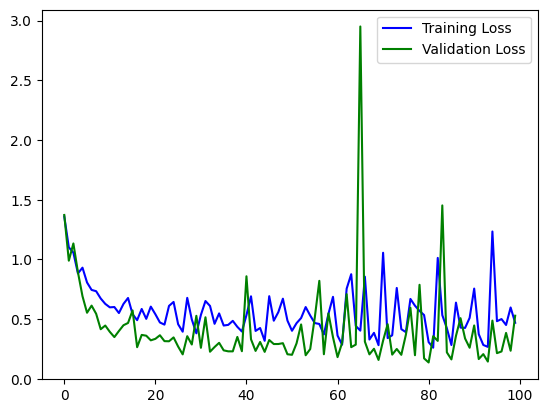

In [17]:
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'g-', label='Validation Loss')
plt.legend()
plt.show()

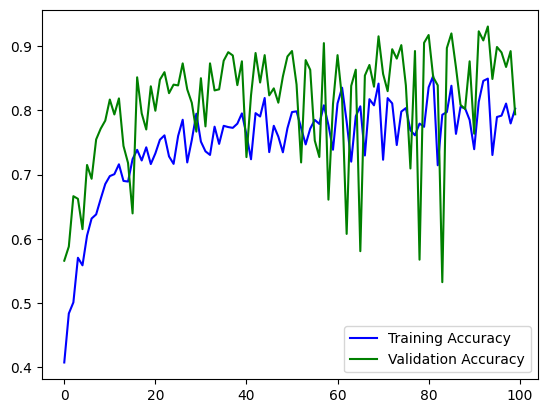

In [18]:
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.legend()
plt.show()

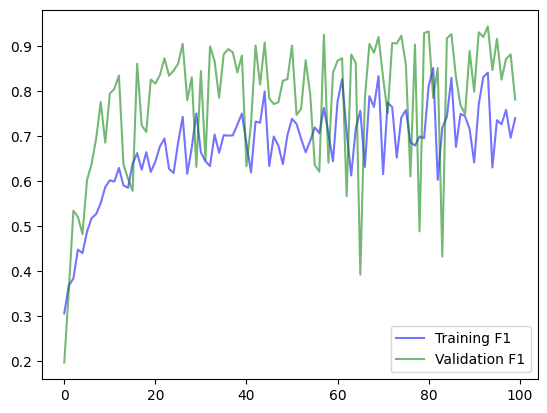

In [19]:
plt.plot(history.history['f1'], 'b-', label='Training F1', alpha=0.55)
plt.plot(history.history['val_f1'], 'g-', label='Validation F1', alpha=0.55)
plt.legend()
plt.show()

In [22]:
y_true, y_pred = [], []
for idx, (img, lab, wgt) in enumerate(val_datagen):
    y_true.extend(lab.argmax(1))
    pred = model.predict(img, verbose=0)
    y_pred.extend(pred.argmax(1))
    if idx == len(val_datagen)-1:
        break

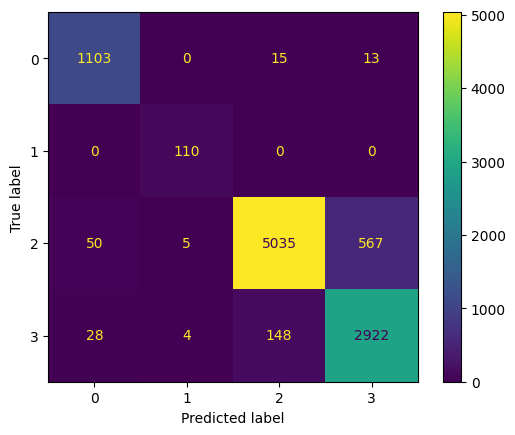

In [23]:
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred);

In [893]:
y_true, y_pred = [], []
for idx, (img, lab) in enumerate(test_datagen):
    y_true.extend(lab.argmax(1))
    pred = model.predict(img, verbose=0)
    y_pred.extend(pred.argmax(1))
    if idx == len(test_datagen)-1:
        break

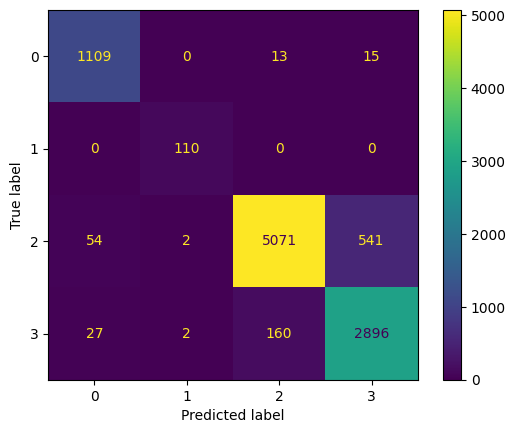

In [894]:
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred);

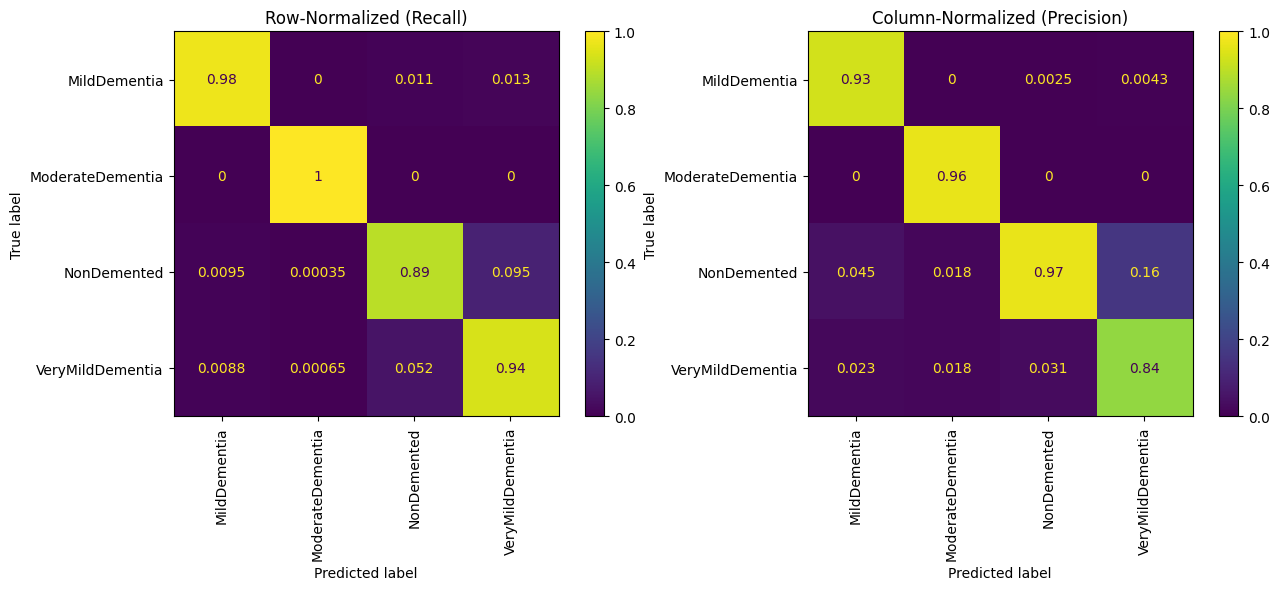

In [895]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, y_pred=y_pred, 
    im_kw=dict(vmin=0, vmax=1),
    xticks_rotation='vertical', display_labels=classes, ax=axes[0], normalize='true')
axes[0].set_title('Row-Normalized (Recall)')
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, y_pred=y_pred, 
    im_kw=dict(vmin=0, vmax=1),
    xticks_rotation='vertical', display_labels=classes, ax=axes[1], normalize='pred')
axes[1].set_title('Column-Normalized (Precision)')
plt.show()

In [897]:
accuracy_score(y_true, y_pred)

0.9186

In [898]:
f1_score(y_true, y_pred, average='macro')

0.93769256572875

----

In [57]:
# https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [886]:
def load_image(path):
    with Image.open(path) as infile:
        img = np.asarray(infile)
    img = tf.image.resize(img, (HEIGHT, WIDTH))
    img = np.expand_dims(img, 0) / 255
    return img

In [58]:
# model = tf.keras.models.load_model('alzheimers_detection_model_6.h5')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 221, 221, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 221, 221, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 108, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 107, 107, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,713,422 (235.42 MB)

 Trainable params: 20,571,140 (78.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,142,282 (156.95 MB)

In [885]:
# imgs, labs = next(iter(test_datagen))

# # layer = 'conv2d_4'
# layer = 'conv2d_5'
# for cls in range(len(classes)):
#     idx = np.where(labs.argmax(1)==cls)[0][0]
#     img = imgs[idx:idx+1,:,:,:]
#     pred = model.predict(img, verbose=0)
#     heatmap = make_gradcam_heatmap(img, model, layer)
    
#     img = tf.image.resize(img, (248, 496))[0,:,:,:]
#     heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
#     axes[0].imshow(img)
#     axes[0].set_xticks([])
#     axes[0].set_yticks([])
#     axes[0].set_title('Scan')
#     axes[1].imshow(heatmap)
#     axes[1].set_xticks([])
#     axes[1].set_yticks([])
#     axes[1].set_title('Grad')
#     fig.suptitle(classes[cls])
#     plt.show()

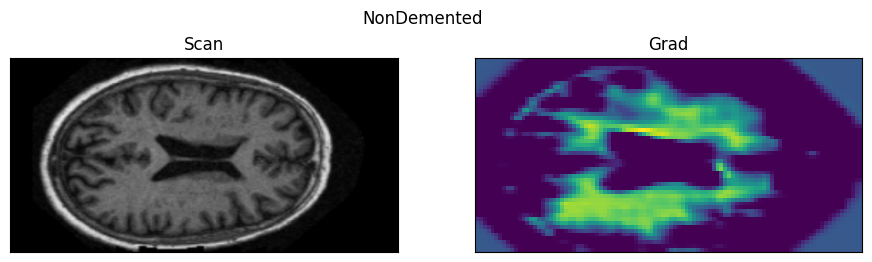

In [887]:
lab = 'NonDemented'
# path = df_test.loc[df_test['class']==lab, 'filename'].values[7]
# path = df_test.loc[df_test['class']==lab, 'filename'].values[21]
path = df_test.loc[df_test['class']==lab, 'filename'].values[19]
img = load_image(path)

pred = model.predict(img, verbose=0)
heatmap = make_gradcam_heatmap(img, model, layer)

img = tf.image.resize(img, (248, 496))[0,:,:,:]
heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
axes[0].imshow(img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Scan')
axes[1].imshow(heatmap)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Grad')
fig.suptitle(lab)
plt.show()

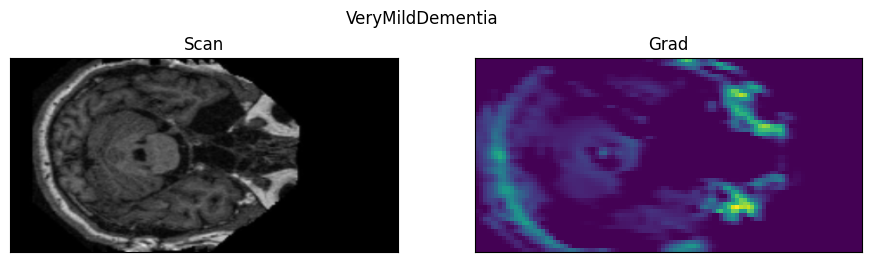

In [888]:
lab = 'VeryMildDementia'
# path = df_test.loc[df_test['class']==lab, 'filename'].values[17]
# path = df_test.loc[df_test['class']==lab, 'filename'].values[20]
path = df_test.loc[df_test['class']==lab, 'filename'].values[50]
img = load_image(path)

pred = model.predict(img, verbose=0)
heatmap = make_gradcam_heatmap(img, model, layer)

img = tf.image.resize(img, (248, 496))[0,:,:,:]
heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
axes[0].imshow(img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Scan')
axes[1].imshow(heatmap)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Grad')
fig.suptitle(lab)
plt.show()

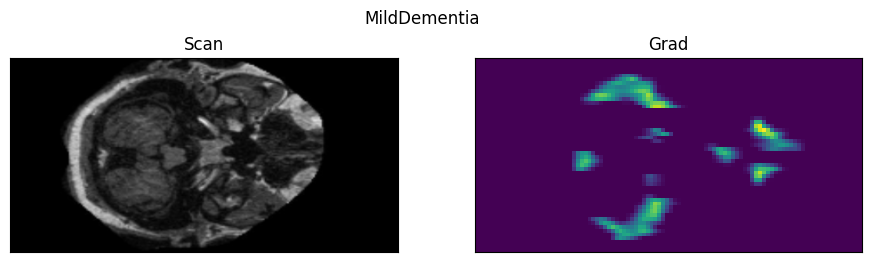

In [889]:
lab = 'MildDementia'
# path = df_test.loc[df_test['class']==lab, 'filename'].values[19]
# path = df_test.loc[df_test['class']==lab, 'filename'].values[98]
path = df_test.loc[df_test['class']==lab, 'filename'].values[104]
img = load_image(path)

pred = model.predict(img, verbose=0)
heatmap = make_gradcam_heatmap(img, model, layer)

img = tf.image.resize(img, (248, 496))[0,:,:,:]
heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
axes[0].imshow(img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Scan')
axes[1].imshow(heatmap)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Grad')
fig.suptitle(lab)
plt.show()

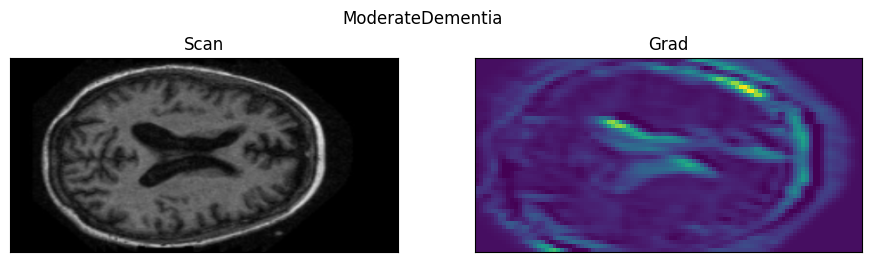

In [890]:
lab = 'ModerateDementia'
path = df_test.loc[df_test['class']==lab, 'filename'].values[8]
# path = df_test.loc[df_test['class']==lab, 'filename'].values[40]
# path = df_test.loc[df_test['class']==lab, 'filename'].values[27]
img = load_image(path)

pred = model.predict(img, verbose=0)
heatmap = make_gradcam_heatmap(img, model, layer)

img = tf.image.resize(img, (248, 496))[0,:,:,:]
heatmap = tf.image.resize(np.expand_dims(heatmap, -1), (heatmap.shape[0], heatmap.shape[1]*2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
axes[0].imshow(img)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Scan')
axes[1].imshow(heatmap)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Grad')
fig.suptitle(lab)
plt.show()

---